# SFS (SequentialFeatureSelector) to chose features subsets: 
LG trained on imbalanced ClinVar with 29 features


In [2]:
import gzip
import pandas as pd
from joblib import dump, load

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import SequentialFeatureSelector as SFS    #  pip install mlxtend  

In [3]:
import sklearn

In [4]:
sklearn.__version__

'1.0.2'

In [5]:
df = pd.read_csv('./01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)
df

/tmp/ipykernel_112/2458230075.py:1: DtypeWarning: Columns (32,49,50,51,54,56,58,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)


,CLNSIG,CADD,AF_ESP,AF_EXAC,AF_TGP,Frq,GNOMADAF,GNOMADAF_popmax,Hom,ORIGIN,...,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL,SpliceAI_pred_SYMBOL,genomic_superdups_frac_match
0,Uncertain_significance,26.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-30.0,11.0,10.0,-30.0,0.01,0.00,0.09,0.00,SAMD11,NaN
1,Likely_benign,13.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,7.0,-34.0,6.0,42.0,0.00,0.02,0.03,0.00,SAMD11,NaN
2,Likely_benign,31.000,NaN,NaN,NaN,0.00056,0.000414,0.000195,NaN,1.0,...,41.0,-47.0,-7.0,44.0,0.00,0.01,0.06,0.00,SAMD11,NaN
3,Uncertain_significance,28.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,10.0,-47.0,34.0,-14.0,0.00,0.00,0.03,0.02,SAMD11,NaN
4,Likely_benign,11.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-35.0,-50.0,12.0,24.0,0.00,0.00,0.01,0.00,SAMD11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468907,Benign,7.587,NaN,NaN,NaN,0.00070,NaN,NaN,5.0,1.0,...,25.0,35.0,0.0,16.0,0.00,0.00,0.00,0.00,USP9Y,NaN
1468908,Uncertain_significance,23.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468909,Benign,11.200,0.00614,0.00589,0.00243,0.00671,NaN,NaN,48.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468910,Uncertain_significance,21.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data preprocessing

In [6]:
""" 1. choose featuresV1"""

featureV1 = ['CLNSIG','CADD', 'AF_TGP', 'Frq', 'IMPACT','GNOMADAF_popmax', 'Hom', 'ORIGIN',
       'SPIDEX', 'SWEGENAF', 'Consequence', 'BIOTYPE', 'SIFT',
       'PolyPhen', 'MES-SWA_acceptor_alt', 'MES-SWA_acceptor_diff',
       'MES-SWA_donor_alt', 'MES-SWA_donor_diff', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'GERP++_RS', 'REVEL_score',
       'phastCons100way_vertebrate', 'phyloP100way_vertebrate', 'LoFtool',
       'pLI_gene_value', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL']         # keep CLNSIG,

df_1 = df[featureV1]



""" 2. only remove missing target """
# for some features with fewer missing
# drop_nan_features = ['CLNSIG','CADD','Consequence','IMPACT','BIOTYPE','MES-SWA_acceptor_alt','MES-SWA_acceptor_diff',
# 'MES-SWA_donor_alt','MES-SWA_donor_diff','pLI_gene_value']

drop_nan_features = ['CLNSIG']
df_1 = df_1.dropna(subset=drop_nan_features)


""" 3. deal with target feature """
# """  CLNSIG: tansfer to 4 classes__ benign,pathogenic,uncertain,others
# NOTE:
# (only count name before |)   explanation-- https://www.ncbi.nlm.nih.gov/clinvar/docs/clinsig/#clinsig_scv

# 1. pathogenic: Pathogenic, Pathogenic/Likely_pathogenic, Likely_pathogenic
# 2. benign: Likely_benign, Benign, Benign/Likely_benign
# 3. uncertain: Uncertain_significance, 
# 4. others: Uncertain_risk_allele, risk_factor, protective, other, not_provided, Likely_risk_allele, drug_response, Conflicting_interpretations_of_pathogenicity, confers_sensitivity, associatio, Affects

df_1 = df_1.copy()
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_significance|_risk_factor', 'Uncertain_significance|_other', 'Uncertain_significance|_drug_response','Uncertain_significance|_association','Uncertain_significance|_Affects','Uncertain_significance'], 'uncertain')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Pathogenic|_risk_factor','Pathogenic|_protective','Pathogenic|_other','Pathogenic|_drug_response|_other','Pathogenic|_drug_response','Pathogenic|_confers_sensitivity','Pathogenic|_association','Pathogenic|_Affects','Pathogenic/Likely_risk_allele','Pathogenic/Likely_pathogenic|_risk_factor','Pathogenic/Likely_pathogenic|_other','Pathogenic/Likely_pathogenic|_drug_response','Pathogenic/Likely_pathogenic','Pathogenic','Likely_pathogenic|_risk_factor','Likely_pathogenic|_other','Likely_pathogenic|_drug_response','Likely_pathogenic|_association','Likely_pathogenic|_Affects','Likely_pathogenic,_low_penetrance','Likely_pathogenic'], 'pathogenic')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Likely_benign|_risk_factor','Likely_benign|_other','Likely_benign|_drug_response|_other','Likely_benign','Benign|_risk_factor','Benign|_protective','Benign|_other','Benign|_drug_response','Benign|_confers_sensitivity','Benign|_association|_confers_sensitivity','Benign|_association','Benign/Likely_benign|_risk_factor','Benign/Likely_benign|_other|_risk_factor','Benign/Likely_benign|_other','Benign/Likely_benign|_drug_response|_other','Benign/Likely_benign|_drug_response','Benign/Likely_benign|_association','Benign/Likely_benign','Benign'], 'benign')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_risk_allele|_risk_factor','Uncertain_risk_allele','risk_factor','protective','protective|_risk_factor','other', 'not_provided','Likely_risk_allele','drug_response|_risk_factor','drug_response|_other','drug_response','Conflicting_interpretations_of_pathogenicity|_risk_factor','Conflicting_interpretations_of_pathogenicity|_protective','Conflicting_interpretations_of_pathogenicity|_other|_risk_factor','Conflicting_interpretations_of_pathogenicity|_other','Conflicting_interpretations_of_pathogenicity|_drug_response|_other','Conflicting_interpretations_of_pathogenicity|_drug_response','Conflicting_interpretations_of_pathogenicity|_association|_risk_factor','Conflicting_interpretations_of_pathogenicity|_association','Conflicting_interpretations_of_pathogenicity','confers_sensitivity','association|_risk_factor','association_not_found','association','Affects|_risk_factor','Affects|_association','Affects'], 'others')

# only keep benign & pathogenic
df_1 = df_1.loc[df_1['CLNSIG'].isin(['benign','pathogenic'])]

# label encoder
map_clnsig={'pathogenic':1,'benign':0}
df_1['CLNSIG']=df_1['CLNSIG'].map(lambda s: map_clnsig.get(s) if s in map_clnsig else s)
# df_1["CLNSIG"].unique()


"""4.2  keep imbalance classes """

# split
from sklearn.model_selection import train_test_split

X, y = df_1.iloc[:, 1:], df_1.iloc[:, 0]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size=0.3,
                    random_state=42,
                    stratify=y)



""" 5. features engineering: transformer"""
## only for training data, no care about target 'CLNSIG', total 29 features

from sklearn.compose import make_column_transformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder                     # # pip install category_encoders
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

## numerical feature group 1 : replace missing with mean;  scaling/standardization

numeric_feature_1 = ['MES-SWA_acceptor_alt','MES-SWA_acceptor_diff','MES-SWA_donor_alt','MES-SWA_donor_diff','MaxEntScan_alt','MaxEntScan_diff','GERP++_RS',
    'phastCons100way_vertebrate','phyloP100way_vertebrate']



## numerical feature group 2 : replace missing with 0;  scaling/standardization
numeric_feature_2 = ['CADD','AF_TGP', 'Frq', 'GNOMADAF_popmax', 'Hom',
       'SWEGENAF','LoFtool','pLI_gene_value','SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG','SpliceAI_pred_DS_DL']



## numerical feature group 3: add missing indicator; replace missing with 0 and ; scaling/standardization
numeric_feature_3 = ['SPIDEX','REVEL_score','SpliceAI_pred_DS_AG']



## categorical ordinal feature group 4: add missing indicator for ['SIFT','PolyPhen']; replace missing with 'missing_value' string; OrdinalEncoder
categori_oridinal_feature_4 =['Consequence','IMPACT','SIFT','PolyPhen']

# ordinal features' order: left to right will be from 0 to length-1
with open('variant_consequences.txt','r') as f:             # get the 'variant_consequences order' lst: descending severity
    order_conseq=[line.rstrip("\n") for line in f] 
    order_conseq.reverse()

ordinal_features = [
    'Consequence',
    'IMPACT',
    'SIFT',
    'PolyPhen']
# 0 is the missing value will be replaced by
ordinal_ordering = [
    order_conseq,
    ['MODIFIER','LOW','MODERATE','HIGH'],
    ['tolerated_low_confidence','tolerated','deleterious_low_confidence','deleterious'],
    ['unknown','benign','possibly_damaging','probably_damaging']
    ]


## categorical nominal feature group 5: replace missing with 0 in ['ORIGIN'], with ''missing_value' in ['BIOTYPE'];  BinaryEncoder
categori_nominal_feature_5 = ['ORIGIN','BIOTYPE']  #,'BIOTYPE'



numeric_feature_1_transformer =make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

numeric_feature_2_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

numeric_feature_3_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

categori_oridinal_feature_4_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  # If None, fill_value will be 0 when imputing numerical data and “missing_value” for strings
    OrdinalEncoder(categories=ordinal_ordering, handle_unknown='use_encoded_value', unknown_value = -1)       # the unknown 'missing_value' string will be enocoded as '-1'
)

categori_oridinal_feature_5_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  
    BinaryEncoder()                                # add new columns, throw the original columns automaticly, 
)


preprocessor = make_column_transformer(
    (numeric_feature_1_transformer, numeric_feature_1),
    (numeric_feature_2_transformer, numeric_feature_2 ),
    (MissingIndicator(), numeric_feature_3 + categori_oridinal_feature_4[2:]),   # add new missing indicators for feature3 + ['SIFT','PolyPhen'] without originial columns,  here: total add 5 indicator columns
    (numeric_feature_3_transformer, numeric_feature_3),  
    (categori_oridinal_feature_4_transformer, categori_oridinal_feature_4),
    (categori_oridinal_feature_5_transformer, categori_nominal_feature_5),                                                    
    # (categori_oridinal_feature_5_transformer, categori_nominal_feature_5[1:])   # for checking: how many ori and biotype derived features seperately; must use [1:] formate, and see the `'BIOTYPE` first, and then can get `origin`
    # remainder='passthrough'                                                   # so here for `BIOTYPE` derived new: 5   ,  `Origin` new: 6 
)

## total features after preprocessor: 43



#  train models

## LG
also for select feature importance

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, C=10, random_state= 42)



In [11]:
preprocessor.fit_transform(X_train)


array([[-0.96125771, -2.57388812,  0.15075876, ...,  0.        ,
         0.        ,  1.        ],
       [-0.91355856,  0.13945432, -0.83543099, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.77713174, -0.08078451, -0.20987442, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.62446176,  0.79629462,  1.32337608, ...,  0.        ,
         0.        ,  1.        ],
       [-0.76755923, -0.07655593, -0.82544688, ...,  0.        ,
         0.        ,  1.        ],
       [-0.39739201, -0.65270072, -0.01174135, ...,  0.        ,
         0.        ,  1.        ]])

In [12]:
X_proce = preprocessor.transform(X)


# SFS
SequentialFeatureSelector: The popular forward and backward feature selection approaches  

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs2 = SFS(lr, 
           k_features=43, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=2,
           n_jobs=-1)

sfs2 = sfs2.fit(X_proce , y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  43 | elapsed:    4.2s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  40 out of  43 | elapsed:    5.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    5.7s finished

[2023-04-28 18:49:05] Features: 1/43 -- score: 0.9492130006625765[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  42 | elapsed:    2.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  39 out of  42 | elapsed:    4.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    4.9s finished

[2023-04-28 18:49:11] Features: 2/43 -- score: 0.9634571323079413[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  41 | elapsed:    3.3s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  36 out of  41 | elapsed:    5.6s remaining:    0.8s
[Parallel

In [14]:
col1 = numeric_feature_1 + numeric_feature_2

col2 = ['miss_SPIDEX', 'miss_REVEL_score', 'miss_SpliceAI_pred_DS_AG', 'miss_SIFT', 'miss_PolyPhen']

col3 = numeric_feature_3 + categori_oridinal_feature_4

col4 = ['ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2', 'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'BIOTYPE_0','BIOTYPE_1','BIOTYPE_2','BIOTYPE_3','BIOTYPE_4']

cols = col1 + col2 + col3 + col4     ## get all columns's names after preprocessing
len(cols)


43

In [15]:
df_sfs_ranf = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
df_sfs_ranf.to_csv('sfs_LG.csv')
df_sfs_ranf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.950453435029563, 0.9479725662955901]",0.949213,"(9,)",0.005337,0.00124,0.00124
2,"(9, 12)","[0.9663578014596915, 0.960556463156191]",0.963457,"(9, 12)",0.012481,0.002901,0.002901
3,"(9, 12, 28)","[0.9702472776195799, 0.9660391577690896]",0.968143,"(9, 12, 28)",0.009053,0.002104,0.002104
4,"(9, 12, 22, 28)","[0.9733502602256806, 0.9690485704025532]",0.971199,"(9, 12, 22, 28)",0.009254,0.002151,0.002151
5,"(9, 12, 22, 26, 28)","[0.9751028005239919, 0.9712259689550005]",0.973164,"(9, 12, 22, 26, 28)",0.00834,0.001938,0.001938
6,"(9, 12, 21, 22, 26, 28)","[0.9776190741124762, 0.9749106027423589]",0.976265,"(9, 12, 21, 22, 26, 28)",0.005827,0.001354,0.001354
7,"(9, 12, 19, 21, 22, 26, 28)","[0.979123780429208, 0.9765341682135216]",0.977829,"(9, 12, 19, 21, 22, 26, 28)",0.005571,0.001295,0.001295
8,"(9, 12, 19, 21, 22, 26, 28, 35)","[0.9804211154552306, 0.9778011562213916]",0.979111,"(9, 12, 19, 21, 22, 26, 28, 35)",0.005636,0.00131,0.00131
9,"(9, 12, 19, 21, 22, 26, 28, 35, 37)","[0.9811089812000222, 0.9784359146844163]",0.979772,"(9, 12, 19, 21, 22, 26, 28, 35, 37)",0.005751,0.001337,0.001337
10,"(9, 10, 12, 19, 21, 22, 26, 28, 35, 37)","[0.981220253599915, 0.9789214669748575]",0.980071,"(9, 10, 12, 19, 21, 22, 26, 28, 35, 37)",0.004945,0.001149,0.001149


In [25]:
## get the features name with index     in dic
feature_names = cols
dic_f=dict(enumerate(feature_names))

### get the feature subsets 7-11 with higher accuracy, names and indice
subsets2 = [6,9,10,12]  ## give how many features the subset includes
feature_selection2= [[] for i in range(4)]     # initialize a nested list  https://www.freecodecamp.org/news/list-within-a-list-in-python-initialize-a-nested-list/
a=0

for i in subsets2:
    
    for j in (sfs2.subsets_[i]['feature_idx']):
        feature_selection2[a].append(dic_f[j])

    a+=1

feature_selection2




[['CADD',
  'GNOMADAF_popmax',
  'miss_REVEL_score',
  'miss_SpliceAI_pred_DS_AG',
  'REVEL_score',
  'Consequence'],
 ['CADD',
  'GNOMADAF_popmax',
  'SpliceAI_pred_DS_DL',
  'miss_REVEL_score',
  'miss_SpliceAI_pred_DS_AG',
  'REVEL_score',
  'Consequence',
  'ORIGIN_3',
  'ORIGIN_5'],
 ['CADD',
  'AF_TGP',
  'GNOMADAF_popmax',
  'SpliceAI_pred_DS_DL',
  'miss_REVEL_score',
  'miss_SpliceAI_pred_DS_AG',
  'REVEL_score',
  'Consequence',
  'ORIGIN_3',
  'ORIGIN_5'],
 ['MaxEntScan_diff',
  'CADD',
  'AF_TGP',
  'GNOMADAF_popmax',
  'SpliceAI_pred_DS_DL',
  'miss_REVEL_score',
  'miss_SpliceAI_pred_DS_AG',
  'REVEL_score',
  'Consequence',
  'ORIGIN_3',
  'ORIGIN_5',
  'BIOTYPE_3']]

In [ ]:
sfs2.subsets_[9]['feature_idx']

(9, 12, 19, 21, 22, 26, 28, 35, 37)

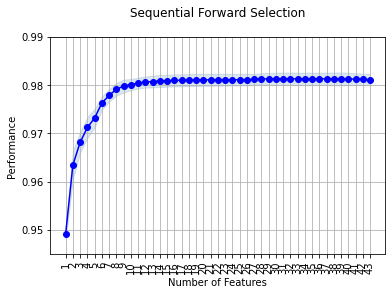

In [20]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig2 = plot_sfs(sfs2.get_metric_dict(), kind='std_dev')

plt.ylim([0.945, 0.99])
plt.title('Sequential Forward Selection',pad=20)
plt.xticks(rotation=90)
plt.grid()
plt.savefig('sfs_rf2_zoom.png')

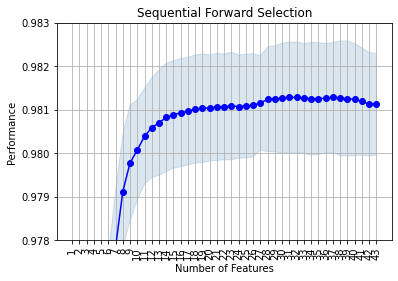

In [24]:
fig2 = plot_sfs(sfs2.get_metric_dict(), kind='std_dev')

plt.ylim([0.978, 0.983])
plt.title('Sequential Forward Selection')
plt.xticks(rotation=90)
plt.grid()
plt.savefig('sfs_rf1.png')